# Determination of the general time trend of the sale prices for the predictive model

In [1]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.3.0-posix-seh-rt_v5-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,6
from datetime import datetime
import warnings
import xgboost as xgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler

warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

## Loading the dataset as a time serie

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y')
data = pd.read_csv("brooklyn_sales_map.csv", parse_dates=['sale_date'], index_col='sale_date', date_parser=dateparse)
# print(data.head())

## Preprocessing the dataset - Manual removal of outliers

In [4]:
data  = data[data.sale_price >= 100000]
data = data[data.sale_price <= 200000000]
data = data[data.year_of_sale > 2009]
data = data[data.year_built > 0]
data = data[data.zip_code > 0]

# Removing outliers manually
data = data.drop(data[data['gross_sqft']>300000])
data = data.drop(data[data['land_sqft']>200000])
data = data.drop(data[data['year_built']<1800])
data = data.drop(data[data['total_units']>200])
data = data.drop(data[data['residential_units']>200])
data = data.drop(data[data['commercial_units']>20])
data = data.drop(data[data['GarageArea']>30000])
data = data.drop(data[data['RetailArea']>30000])
data = data.drop(data[data['OfficeArea']>30000])
data = data.drop(data[data['UnitsRes']>400])
data = data.drop(data[data['NumFloors']>40])


data_cols = list(data.columns.values)
want = [ 'index','sale_price' ]

for i in data_cols:
    if i not in want:
        data = data.drop(i, axis=1)

## Organizing the dataset - Sorting and removal of duplicates

In [5]:
#Sort the sales by sale_price in descending order
data = data.sort_values(by='sale_price', ascending=False)

# Select the highest sale value among the sales that happened on the same day
data = data[~data.index.duplicated(keep='first')]

#Sort the sales by sale_date in ascending order
data = data.sort_index()

## Determination of the general time trend

In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=360)
    rolstd = pd.rolling_std(timeseries, window=360)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.title('Rolling Mean')
    plt.xlabel('Sale date')
    plt.ylabel('Sale price')
    plt.show(block=False)
    
#     #Perform Dickey-Fuller test:
#     print ('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)

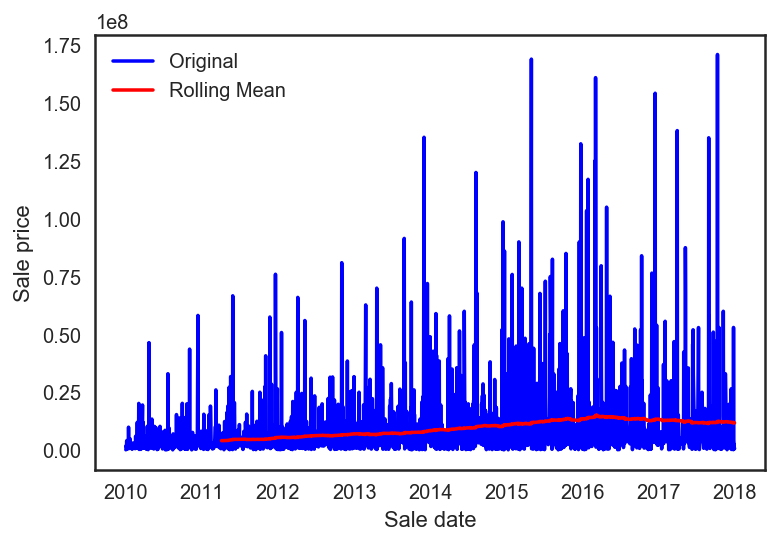

In [7]:
test_stationarity(data)

In [8]:
#Normalizing data - log transformation
data_log = np.log(data)

#Determination of the moving_average/rolling_mean
moving_avg = pd.rolling_mean(data_log, 365)

moy = moving_avg.values.tolist()

#Remove the first 364 values of the moving_avg that are not defined
#because we take the average of last 365 values to determine pd.rolling _mean
moy = moy[364:]

mov_avg = [item for sublist in moy for item in sublist]

In [9]:
#Transform the time_serie indexes into number of days since first day analyzed (2010-01-01)
d_day = [0]

for i in range(data.index.size-1):
    delta = data.index[i+1] - data.index[0]
    d_day.append(delta.days)
    
d_day = d_day[364:]

In [10]:
from sklearn.metrics import mean_squared_error

# Split the data into training/testing sets

# date_train = d_day[:-1095]
# date_train = np.asarray(date_train)
# date_test = d_day[-1095:-400]
# date_test = np.asarray(date_test)

#Prediction to two years
date_train = d_day[:-730]
date_train = np.asarray(date_train)
date_test = d_day[-730:]
date_test = np.asarray(date_test)


# Split the targets into training/testing sets

# time_trend_train = mov_avg[:-1095]
# time_trend_train = np.asarray(time_trend_train)
# time_trend_test = mov_avg[-1095:-400]
# time_trend_test = np.asarray(time_trend_test)

time_trend_train = mov_avg[:-730]
time_trend_train = np.asarray(time_trend_train)
time_trend_test = mov_avg[-730:]
time_trend_test = np.asarray(time_trend_test)

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(date_train.reshape(-1,1), time_trend_train.reshape(-1,1))

# Make predictions using the testing set
time_trend_pred = regr.predict(date_test.reshape(-1,1))

# # The coefficients
#Determine and Print Slope and Intercept
slope = regr.coef_
intercept = regr.intercept_
print('Coefficients: \n','Slope:', slope,'Intercept:', intercept)
c = 0.5866

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(time_trend_test, time_trend_pred))

# # Plot outputs
# plt.scatter(date_test, time_trend_test,  color='black')
# plt.plot(date_test, time_trend_pred, color='blue', linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()

Coefficients: 
 Slope: [[0.00056817]] Intercept: [14.43700909]
Mean squared error: 0.07


## Modify the dataset to remove the time trend from the sale price and make it stationary

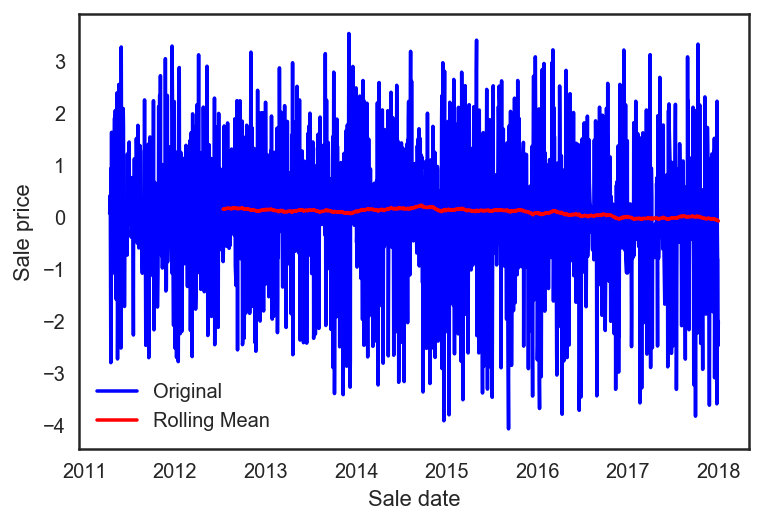

In [11]:
#Calculate the difference between the normaized data(sale_price) and the moving_average to make the time_series stationary
data_log_moving_avg_diff = data_log - moving_avg
data_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(data_log_moving_avg_diff)

## Estimate the sale price based only on the building specific features without taking into account the time trend (cf price estimation notebook)

## Apply the time trend determined before to the estimated sale price to account for the time impact

In [12]:
#Calculate the predictive sale price based on the stationary log_sale_price and the predictive moving_average
log_stat_price = data_log_moving_avg_diff.values.tolist()
time_trend_pred = time_trend_pred.tolist()
log_stat_price_test = log_stat_price[-730:]
log_stat_price_test = [item for sublist in log_stat_price_test for item in sublist]
time_trend_pred = [item for sublist in time_trend_pred for item in sublist]

#Sum the stationary logarithmic sale price and the predictive moving average to obtain the predictive logarithmic sale price
log_sale_price_pred = [sum(i) for i in zip(log_stat_price_test,time_trend_pred)]

#Apply the exponential function
sale_price_pred = c*np.exp(log_sale_price_pred)


#Compare the predictive sale_price to the actual sale_price
sale_p = data.values.tolist()
sale_p = [item for sublist in sale_p for item in sublist]
sale_price_test = sale_p[-730:]
sale_price_test = np.asarray(sale_price_test)
sale_price_pred = np.asarray(sale_price_pred)

In [13]:
sum = 0
num = 100

for i in range(num):
    delta = abs((sale_price_test[-i] - sale_price_pred[-i])/sale_price_test[-i])
    sum += delta
mean = (sum/num)*100
print('Mean predictive error:',round(mean,1),'%')

Mean predictive error: 7.7 %
